In [1]:
import os

import langchain
import pandas as pd
from dotenv import load_dotenv
from langchain.agents import AgentExecutor
from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_openai import OpenAI
from sklearn.datasets import load_iris, load_wine

from custom_react_agent import create_react_agent
from prompt_template import llama_pandas_template

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

In [3]:
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)

In [3]:
# model_path = "models/llama-2-7b-chat.Q5_K_M.gguf"
# model_path = "models/llama-2-13b-chat.Q4_K_M.gguf"
model_path = "models/mistral-7b-instruct-v0.2.Q5_K_M.gguf"

n_gpu_layers = 25       # Change this value based on your model and your GPU VRAM pool.
n_batch = 32            # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
context_window = 4096

llm = LlamaCpp(
    model_path=model_path,
    n_ctx=context_window,
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 0 | VSX = 0 | 


In [8]:
df = load_wine(return_X_y=True, as_frame=True)[0]

# in the shell all packages from this env are available
shell = PythonAstREPLTool(locals={"df": df})

shell.run(
    "import numpy as np; import matplotlib.pyplot as plt; import pandas as pd; import seaborn as sns"
)

tools = [shell]

prompt = PromptTemplate(
    input_variables=["agent_scratchpad", "input", "tools", "dfhead"],
    template=llama_pandas_template,
)

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
)



> Entering new AgentExecutor chain...
I can use the seaborn library to plot a heatmap of the correlation matrix.
Action: python_repl_ast
Action Input: sns.heatmap(df.corr(), annot=True)
Axes(0.125,0.11;0.62x0.77) I now know the final answer
Final Answer: A heatmap of the correlation matrix has been plotted using the seaborn library.

> Finished chain.


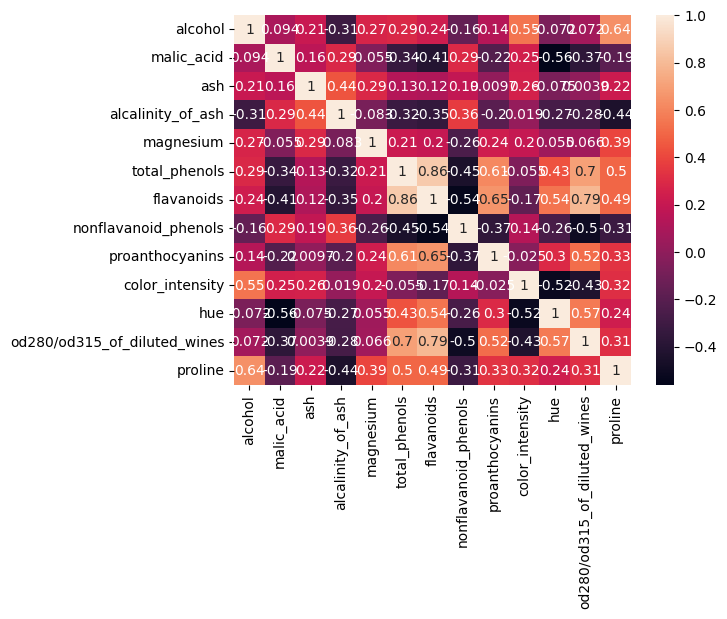

In [11]:
answer = agent_executor.invoke(
    {"input": "could you plot the correlation matrix?"}
)